First Version Of Team Project - Gun Violence in US  
Team : Kushall Dayal, Srinivasan Vasudevan, Marvin Miranda Olmedo, Hariz Hisham, Qing Zhang

# Core Message:
## There are higher rates of civilian firearm ownership in the United States because of relaxed laws across states as well as pro-firearm ownership lobbyists buying their way into Congress

## Audience: Policy makers & gun control activist

## Chart-1: States with more guns see more firearm deaths

Data Source: https://webappa.cdc.gov/sasweb/ncipc/mortrate.html
             Statewise gun control laws : https://raw.githubusercontent.com/srivasud/Group7/master/data/lawsstate.csv
+ We downloaded the Firearm deaths by State for the year 1999 to 2017
+ To get the registered firearms by State between 2010 to 2017, we used our existing data from [github](https://raw.githubusercontent.com/srivasud/Group7/master/data/licensed_ownership_bystate_wospace.csv) 
  (We made a small modification to the existing data in the csv to remove "_" between names to keep the state names consistent across various datasets)
+ We also downloaded Statewide gun laws from [source](https://raw.githubusercontent.com/srivasud/Group7/master/data/lawsstate.csv)
+ We chose year 2016 specifically for all our charts for the following reasons
   + Every aspect of our story has the same consistent year
   + Data for gun ownership and firearm deaths are not available post 2017
+ We cleaned and merged the datasets
+ Calcuated Deaths_Rate (per 100K) = (TotalDeaths/TotalPopulation)*100000 (We chose Total population instead of Adult population because the total deaths included children as well)
+ We calculated Guns_PerCapita = (Total Weapons/Total population)*1000
+ Our final cleaned dataframe output for year 2016 is given below. Here are the column descriptions.
    + State - Name of the State
    + Year	- Year of the data
    + StateCode	- 2 character abbreviation of statecode
    + Guns_PerCapita - (Total Weapons/Total population)*1000
    + Deaths_Rate - (TotalDeaths/TotalPopulation)*100000
    + TotalDeaths - Homicide deaths+Suicide deaths by firearm
    + lawtotal - Total count of firearm regulation laws in that state
    
+ We plotted Guns_PerCapita on X-axis and Deaths_rate on Y-axis.

**Arguments:**
+ We found that Wyoming seems to be an outlier with respect to Guns_PerCapita with a value of 227, while the mean Guns_PerCapita including Wyoming is 22.275. Keeping Wyoming in the data and plotting the scatter plot, the trend in the chart is hard to visualize and comprehend (as shown below in our first chart below). Hence we decided to exclude Wyoming from the first chart and produced the second visualization. We can very clearly see the trend of gun deaths increases as gun ownership shifts to right!
+ Interestingly Wyoming being highest in gun ownership is not the highest in gun deaths per 100K people.
+ The death rate spikes up sharply in states which have gun ownership per capita more than 15 (such as Oregon, Ohio, Georgia, Kentucky, Oklahoma etc).
+ It is very clear that the increased firearm availability per capita is positively correlated with the increase in deaths per 100K people.

In [1]:
%pylab inline
import pandas as pd 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
# utility method to return a dataframe filtered by given year and sort by total laws descending
def show_laws_year(year,law_state):
   x = law_state[law_state['year'] == year].reset_index(drop = True)
   x = x.sort_values(by = 'lawtotal', ascending = False)
   return x

In [3]:
# prepare dataframe for the passed year
def returnProcessedDF(year):
    # Read Firearm homicide data from CDC website
    homi_state=pd.read_csv('https://raw.githubusercontent.com/srivasud/Group7/master/data/FirearmHomicideByState-99-2017.csv')
    # Read Firearm suicide data from CDC website
    suicide_state=pd.read_csv('https://raw.githubusercontent.com/srivasud/Group7/master/data/FirearmSuicideByState-99-2017.csv')

    # merge the two datasets by State and Year
    deaths_state=pd.merge(homi_state,suicide_state,on=["State","Year"],how='left')

    # Fill nas with zeros
    deaths_state=deaths_state.fillna(0)
    # convert SuicideDeaths to integer to avoid display 127.0
    deaths_state['SuicideDeaths']=deaths_state['SuicideDeaths'].values.astype(np.int)

    # Calculate Deaths_Rate Per 100K=(TotalDeaths/TotalPopulation)*100000 and round to 1 decimal place
    deaths_state['Deaths_Rate']=round(((deaths_state.HomicideDeaths+deaths_state.SuicideDeaths)/(deaths_state.TotalPopulation))*100000,1)

    # state abbreviation
    stateabbr=pd.read_csv('https://raw.githubusercontent.com/srivasud/Group7/master/data/Abbr.csv')
    # drop extra columns(not needed)
    stateabbr=stateabbr.drop(["Unnamed: 2"],axis=1)
    stateabbr=stateabbr.drop(["Unnamed: 3"],axis=1)

    # rename abbr to StateCode
    stateabbr=stateabbr.rename(columns={"state":"State","abbr":"StateCode"})

    # merge deaths by state with state abbreviation dataset
    deaths_state=pd.merge(deaths_state,stateabbr,on="State",how="inner")

    # gun ownership processing
    # read from licensed_ownership_bystate.csv
    df=pd.read_csv('https://raw.githubusercontent.com/srivasud/Group7/master/data/licensed_ownership_bystate_wospace.csv')
    df=df[df.Year==year]
    df.reset_index(inplace=True)
   
    # select State,Year and Total Weapons only
    final_dff=df[["State","Year","Total"]]
    final_dff=final_dff.drop_duplicates()

    # rename Total to Total_Firearms
    final_dff=final_dff.rename(columns={"Total":"Total_Firearms"})
    # merge deaths_state with final_dff (total firearms by state,year)
    deaths_state=pd.merge(deaths_state,final_dff,on=["State","Year"],how="inner")
    # calculate Guns_Per1000 as TotalFirearms/AdultPopulation times 1000
    deaths_state['Guns_PerCapita']=round((deaths_state['Total_Firearms']/deaths_state['TotalPopulation'])*1000)

    deaths_state = deaths_state.sort_values(by=['Guns_PerCapita','Deaths_Rate'], ascending=False)
    deaths_state['TotalDeaths']=deaths_state.HomicideDeaths+deaths_state.SuicideDeaths
    newdf = deaths_state[deaths_state.Year==year]
    max_value = newdf["Guns_PerCapita"].max()
    min_value = newdf["Guns_PerCapita"].min()
    newdf["Normalized_Guns_PerCapita"] = (newdf["Guns_PerCapita"] - min_value) / (max_value - min_value)
    newdf=newdf.sort_values(by=['Normalized_Guns_PerCapita','Deaths_Rate'], ascending=False)[['State','Year','StateCode','Guns_PerCapita','Deaths_Rate','TotalDeaths']]

    # read state wise total law counts
    law_state=pd.read_csv('https://raw.githubusercontent.com/srivasud/Group7/master/data/lawsstate.csv')
    law_state_n = show_laws_year(2016,law_state)
    law_state_n=law_state_n.rename(columns={"state":"State"})
    law_state_n = law_state_n.iloc[:,[0,-1]]
    # sort values by state & show head
    law_state_n = law_state_n.sort_values(by=['State'])

    # merge the data frame
    newdf=pd.merge(newdf,law_state_n,on=["State"],how="outer")
    # fill nan with 0
    newdf=newdf.fillna(0)
    return newdf

,State,Year,StateCode,Guns_PerCapita,Deaths_Rate,TotalDeaths,lawtotal
18,West Virginia,2016,WV,19.0,17.3,316,18.0
33,Minnesota,2016,MN,14.0,7.5,415,41.0
22,Kansas,2016,KS,18.0,12.7,370,4.0
26,Colorado,2016,CO,17.0,14.0,774,30.0
35,Mississippi,2016,MS,12.0,18.4,550,2.0
29,Tennessee,2016,TN,15.0,16.7,1109,22.0
17,Texas,2016,TX,21.0,11.6,3238,18.0
16,South Carolina,2016,SC,21.0,17.3,860,12.0
19,Oklahoma,2016,OK,18.0,19.3,755,9.0
11,South Dakota,2016,SD,25.0,11.4,98,5.0


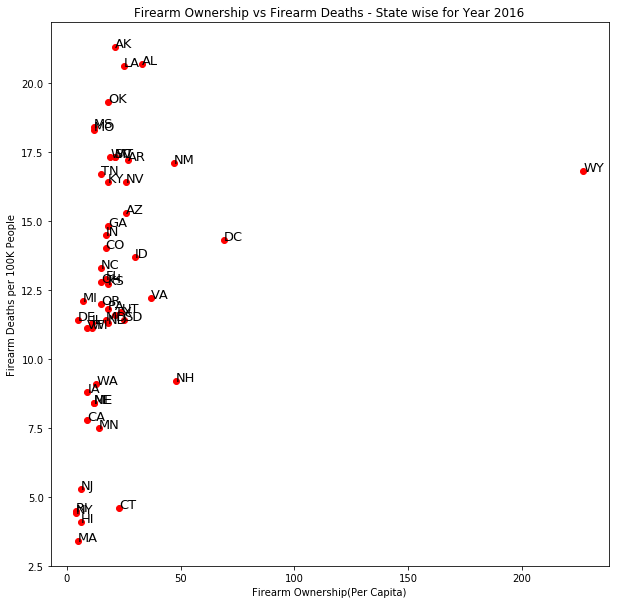

In [4]:
plt.rcParams['figure.figsize'] = (10,10)
year=2016
newdf = returnProcessedDF(year)    # invoke the above method for year 2016


#max_value = newdf["Guns_Per1000"].max()
#min_value = newdf["Guns_Per1000"].min()
#newdf["normalized_gper1000"] = (newdf["Guns_Per1000"] - min_value) / (max_value - min_value)

# Wyoming is an outlier with Guns_Per1000 as 298 and the rest of the states
# have Guns_Per1000 < 60. Need to discuss on this. For now filtering this outlier...
#!newdf = newdf[newdf.State!='Wyoming']

X = newdf.Guns_PerCapita.values
Y = newdf.Deaths_Rate.values
n = newdf.StateCode.values

fig, ax = plt.subplots()
ax.scatter(X, Y, color='red')
for i, txt in enumerate(n):
    ax.annotate(txt, (X[i], Y[i]), fontsize=13 )
        
plt.xlabel('Firearm Ownership(Per Capita)')
plt.ylabel('Firearm Deaths per 100K People')
plt.title('Firearm Ownership vs Firearm Deaths - State wise for Year '+str(year))
newdf.sample(10)

Text(0.5, 1.0, 'Firearm Ownership vs Firearm Deaths - State wise for Year 2016 Excluding Wyoming')

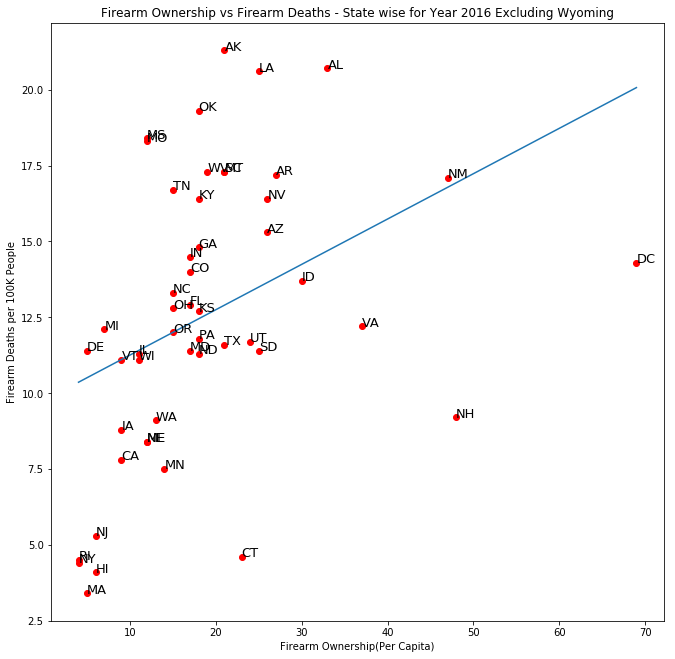

In [5]:
# Plot for the picture-2 without outlier Wyoming...
plt.rcParams['figure.figsize'] = (11,11)
year=2016
newdf = returnProcessedDF(year)    # invoke the above method for year 2016


#max_value = newdf["Guns_Per1000"].max()
#min_value = newdf["Guns_Per1000"].min()
#newdf["normalized_gper1000"] = (newdf["Guns_Per1000"] - min_value) / (max_value - min_value)

# Wyoming is an outlier with Guns_Per1000 as 298 and the rest of the states
# have Guns_Per1000 < 60. Need to discuss on this. For now filtering this outlier...
newdf = newdf[newdf.State!='Wyoming']

X = newdf.Guns_PerCapita.values
Y = newdf.Deaths_Rate.values
n = newdf.StateCode.values

fig, ax = plt.subplots()
ax.scatter(X, Y, color='red')
for i, txt in enumerate(n):
    ax.annotate(txt, (X[i], Y[i]), fontsize=13 )
plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)))
        
plt.xlabel('Firearm Ownership(Per Capita)')
plt.ylabel('Firearm Deaths per 100K People')
plt.title('Firearm Ownership vs Firearm Deaths - State wise for Year '+str(year)+' Excluding Wyoming')

## Chart-2: States with stronger and more gunlaws see less firearm deaths

Data Source: http://www.statefirearmlaws.org/national-data/2016
             
+ Statewide count of laws is downloaded from the above statefirmarmlaws.org for the year 2016.
+ Death rate per 100K people is calculated from the same datasource as chart-1.
+ Data is processed and cleaned to get the result. The below code snippet does the data cleansing.
+ All of the preprocessing of data is done by a function returnProcessedDF (above common for chart-1 and chart-2)

### Findings/Argument:
+ States with less number of gun control laws have higher deaths due to firearms (evident from the trend line that the death rate per 100K reduces at the right end of the line).
+ An interesting finding here is almost 70% of states (35 states) have each less than 25 gun control laws or provisions.
+ Another fact is that there are 36 states with more than 10 deaths per 100K people.
+ Unexpectedly even though states such as Denver, Illinois, Maryland, Oregon, Pennsylvania have stricter laws they have higher death rates (more than 10 deaths per 100K people).

In [6]:
# Call the generic routine which returns a dataframe cleaned and processed
Gunrate=returnProcessedDF(2016)
Gunrate.sample(10)

,State,Year,StateCode,Guns_PerCapita,Deaths_Rate,TotalDeaths,lawtotal
0,Wyoming,2016,WY,227.0,16.8,98,6.0
2,New Hampshire,2016,NH,48.0,9.2,123,10.0
4,Virginia,2016,VA,37.0,12.2,1024,13.0
46,Hawaii,2016,HI,6.0,4.1,59,79.0
19,Oklahoma,2016,OK,18.0,19.3,755,9.0
43,California,2016,CA,9.0,7.8,3062,104.0
38,Nebraska,2016,NE,12.0,8.4,161,22.0
37,Maine,2016,ME,12.0,8.4,112,11.0
50,New York,2016,NY,4.0,4.4,880,76.0
30,North Carolina,2016,NC,15.0,13.3,1346,30.0


Text(0.5, 1.0, 'Gun Laws vs. Gun Deaths')

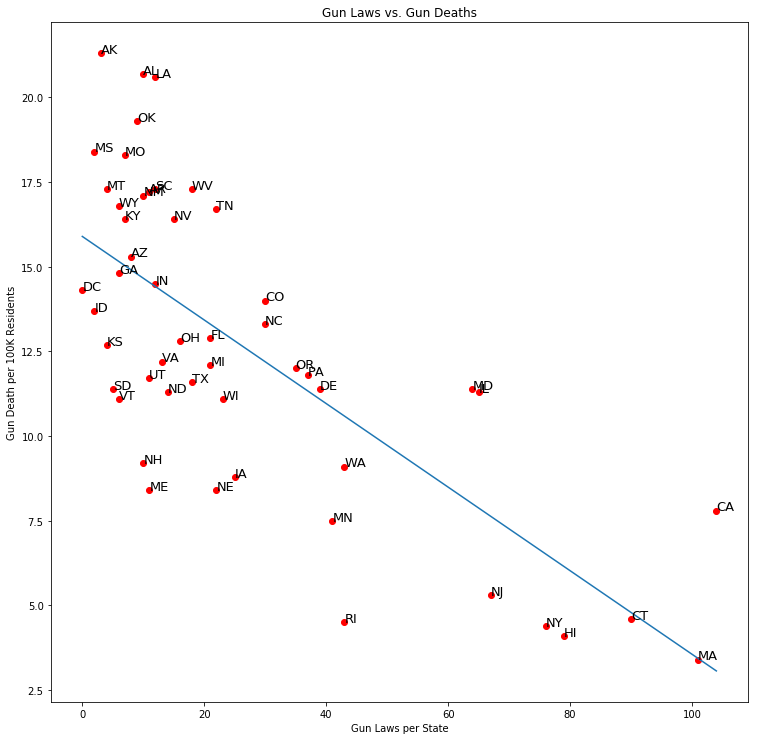

In [7]:
# list of state abbreviations 
my_list = Gunrate.StateCode.values
x = Gunrate.lawtotal
y = Gunrate.Deaths_Rate
plt.rcParams['figure.figsize'] = (12.5,12.5)
Y = y
X = x
n = my_list


fig, ax = plt.subplots()
ax.scatter(X, Y, color='red')
for i, txt in enumerate(n):
    ax.annotate(txt, (X[i], Y[i]), fontsize=13 )
    
plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)))
    
plt.xlabel('Gun Laws per State')
plt.ylabel('Gun Death per 100K Residents')
plt.title('Gun Laws vs. Gun Deaths')


## Chart-3: Congress is not acting enough because gun ownership lobbyists are funding the congress!!!

+ Data collected from [here](https://www.opensecrets.org/news/issues/guns).
+ Alternatively, use this [link](https://docs.google.com/spreadsheets/d/1-7PdCI2NawSgP1QE-cGYVYedetYqepR-4jBweaJyqFo/edit#gid=1782600961)
  
### Findings/Argument:

+ Congress is not able to create more laws to control gun ownership because the lobbyists who support gun ownership receive more funds than the gun control group.

+ Republican senators are funded far more by firearm rights lobbyists than those in the House of Representatives. Since the Senate has less people, it's surprising that there is a higher funding rate per congressman for Senators than there is for Representatives. This is probably due to the fact that Senators can overturn legislation passed by the House since they have more legislative power.

+ Some Democratic Senators and Representatives are being funded by firearm rights lobbyists! This could mean that the issue with gun control is not necessarily a bilateral issue, but could be a more deeply rooted issue in American society.

+ Independents are joining in on the conversation.

+ Funding plays a key role in civilian firearm ownership rates

In [27]:
fund = pd.read_csv('https://raw.githubusercontent.com/srivasud/Group7/master/congress_funding.csv', index_col = False)

# Create a new column with state label for downstream purposes
# We'll use this when exploring how much funding from lobbyists each state receives
fund['Stateid'] = fund.Distid.str[:2]
fund = fund.drop(columns = ['Unnamed: 10', 'Unnamed: 11'])  # Drop unwanted columns

# Add total funding from gun control and gun rights to new col 'Total Funding' 
# to check how much funding each congressman receives from lobbyist 
fund['Total Funding'] = fund['Total from Gun Control'] + fund['Total From Gun Rights']

# Next, we label each congressman which 'stance' they are on based on which lobbyist pays them more.
# If congressman receives more from gun control, label as 'Control'; similar for gun rights.
# If they are not funded by gun control/rights lobbyist, or have equal funding, they are 'undecided'
# This will be useful in categorization when visualizing funding purposes
fund['Stance'] = np.where(fund['Total from Gun Control'] > fund['Total From Gun Rights'], 'Control', 'Rights')
fund['Stance'] = np.where(fund['Total from Gun Control'] == fund['Total From Gun Rights'], 'Undecided', fund['Stance'])

# We log the funding to scale down large differences between categories
fund['log_grights'] = log(1 + fund['Total From Gun Rights'])
fund['log_gcontrol'] = log(1 + fund['Total from Gun Control'])
fund['log_totalfund'] = log(1 + fund['Total Funding'])

# Rename variables for Party and Office
fund.Party = np.where(fund.Party == 'R', 'Republican', fund.Party)
fund.Party = np.where(fund.Party == 'D', 'Democrat', fund.Party)
fund.Party = np.where(fund.Party == 'I', 'Independent', fund.Party)
fund.Office = np.where(fund.Office == 'S', 'Senate', 'House')

# Filter the data to only show Republican and Democrat
fund_c = fund[fund.Party != 'Independent']
fund_c = fund_c[fund_c.Stance != 'Undecided']

### DON'T RUN ###
#fund_c.to_csv('fund_c_tableau.csv', index = False)
### DON'T RUN ###

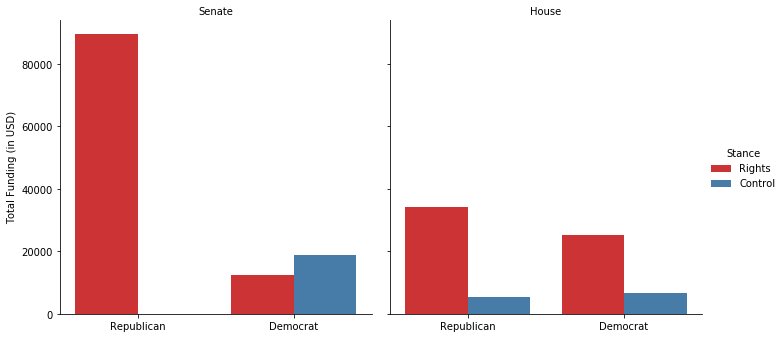

In [25]:
X = 'Party'
y = 'Total Funding'

g = sns.catplot(X, y, col = 'Office', hue = 'Stance', data = fund_c,\
                kind = 'bar', palette = 'Set1', ci = None)

g.set_axis_labels("", "Total Funding (in USD)").set_titles("{col_name}");

## Road map for Future enhancement:
* We will come up with a dashboard putting together all these 3 charts.
* For Chart-1, we will try to come up with a better trend line (exponential trend line).
* In the Chart-3, refine the meaning of 'Undecided' category (i.e. what if they're funded amount 6,500 from gun rights and `$5,900` from gun control?).
* In the Chart-3, use full labels for categories (e.g. Republicans instead of 'R', Senate instead of 'S').
* In the Chart-3, instead of 'Office = S' labels, use 'Senate'. Similar for House of Reps.
* Comeup with a different visualization for Chart-3 showing the trend of funds received by various state.